In [39]:
# !pip install -U scikit-learn pandas xgboost openpyxl
# !pip uninstall -y torch torchvision torchaudio transformers sentence-transformers
# !pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --extra-index-url https://download.pytorch.org/whl/cu118
# !pip install transformers==4.35.2
# !pip install sentence-transformers==2.2.2
# !pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --extra-index-url https://download.pytorch.org/whl/cu118
# !pip install transformers==4.35.2 sentence-transformers==2.2.2 huggingface_hub==0.16.4
# !pip install matplotlib
# !pip install seaborn

In [40]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
import joblib

In [41]:
dataset  =  pd.read_excel('data_for_hvp_rankings.xlsx')

In [42]:
traits = ['VQ A 6', 'VQ B 9', 'VQ C 10', 'VQ D 11',
       'VQ E 13', 'VQ F 5', 'VQ G 17', 'VQ H 16', 'VQ I 12', 'VQ J 4',
       'VQ K 1', 'VQ L 18', 'VQ M 2', 'VQ N 14', 'VQ O 8', 'VQ P 15', 'VQ Q 3',
       'VQ R 7', 'SQ A 6', 'SQ B 9', 'SQ C 10', 'SQ D 11', 'SQ E 13', 'SQ F 5',
       'SQ G 17', 'SQ H 16', 'SQ I 12', 'SQ J 4', 'SQ K 1', 'SQ L 18',
       'SQ M 2', 'SQ N 14', 'SQ O 8', 'SQ P 15', 'SQ Q 3', 'SQ R 7']

In [43]:
X = dataset["Message"]
y = dataset[traits]

In [44]:
sbert = SentenceTransformer("all-mpnet-base-v2")

In [45]:
embedded_sequences = []

for txt in tqdm(X, desc="Encoding Messages"):
    
    embeddings = sbert.encode(txt, convert_to_numpy=True)
    embedded_sequences.append(embeddings)

X_embedded = np.array(embedded_sequences)

Encoding Messages: 100%|██████████| 667/667 [09:05<00:00,  1.22it/s]


In [46]:
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

def train_xgboost_pipeline(X, y):

    xgb = MultiOutputRegressor(
        XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="reg:squarederror",
            tree_method="hist",
            n_jobs=-1
        )
    )
    xgb.fit(X, y)
    joblib.dump(xgb, "xgb_pipeline.pkl")
    print("Model saved as xgb_pipeline.pkl")
    return xgb


In [47]:
from sentence_transformers import SentenceTransformer
import numpy as np

def predict_traits(text_list, model):
    embeddings = sbert.encode(text_list, convert_to_numpy=True)
    return model.predict(embeddings)


In [48]:
model = train_xgboost_pipeline(X_embedded,y)

Model saved as xgb_pipeline.pkl


In [49]:
model = joblib.load("xgb_pipeline.pkl")

In [50]:
pred = predict_traits(["This is a sample text"],model)
print(pred)

[[ 6.5890436  6.8628135 12.1096115 11.498295  13.254711   6.1307855
  14.706985  15.288     12.389409   4.353411   4.6046243 16.728338
   3.739322  13.653627  11.124858  12.228891   5.78421    6.157141
   5.082336   6.140429  12.482017   9.355719  11.07123    9.017599
  13.770868  13.076485  11.539981   7.43428    4.9873047 12.530985
   6.795062  11.32442    6.2173476  9.804873   7.7320886  5.743667 ]]


In [51]:
y_pred = model.predict(X_embedded)


In [52]:
r2_score(y,y_pred)

0.9431158900260925

In [53]:
from sklearn.metrics import r2_score, mean_absolute_error

print("R²:", r2_score(y, y_pred, multioutput='uniform_average'))
print("MAE:", mean_absolute_error(y, y_pred, multioutput='uniform_average'))


R²: 0.9431158900260925
MAE: 0.25052332878112793


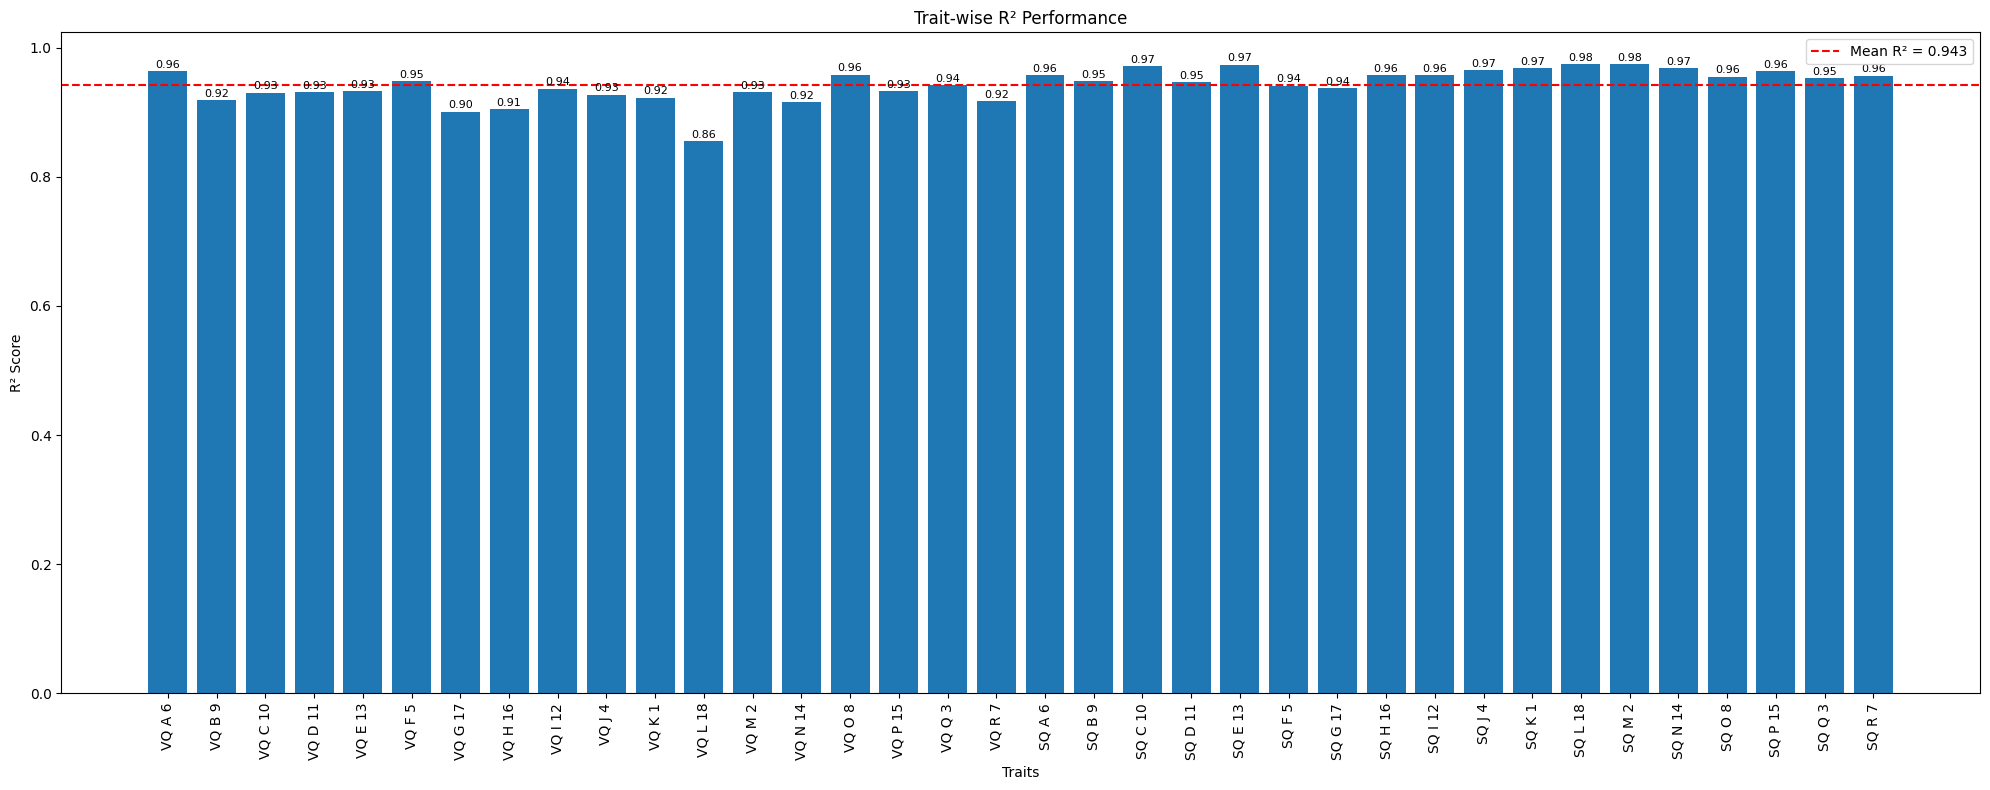

<Figure size 640x480 with 0 Axes>

In [81]:
# Compute R² per trait
r2_scores = [r2_score(y[:, i], y_pred[:, i]) for i in range(y.shape[1])]
mean_r2 = np.mean(r2_scores)

plt.figure(figsize=(20,8))  # wide but not crazy wide
plt.bar(traits, r2_scores)

# Mean line
plt.axhline(mean_r2, color='red', linestyle='--', label=f"Mean R² = {mean_r2:.3f}")

plt.xlabel("Traits")
plt.ylabel("R² Score")
plt.title("Trait-wise R² Performance")

# Rotate X labels so they don't overlap
plt.xticks(rotation=90)

# Add score above bars
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', fontsize=8)

plt.tight_layout()
plt.legend()
plt.show()
plt.savefig("Trait-wise-r2Score.png", dpi=300, bbox_inches="tight")


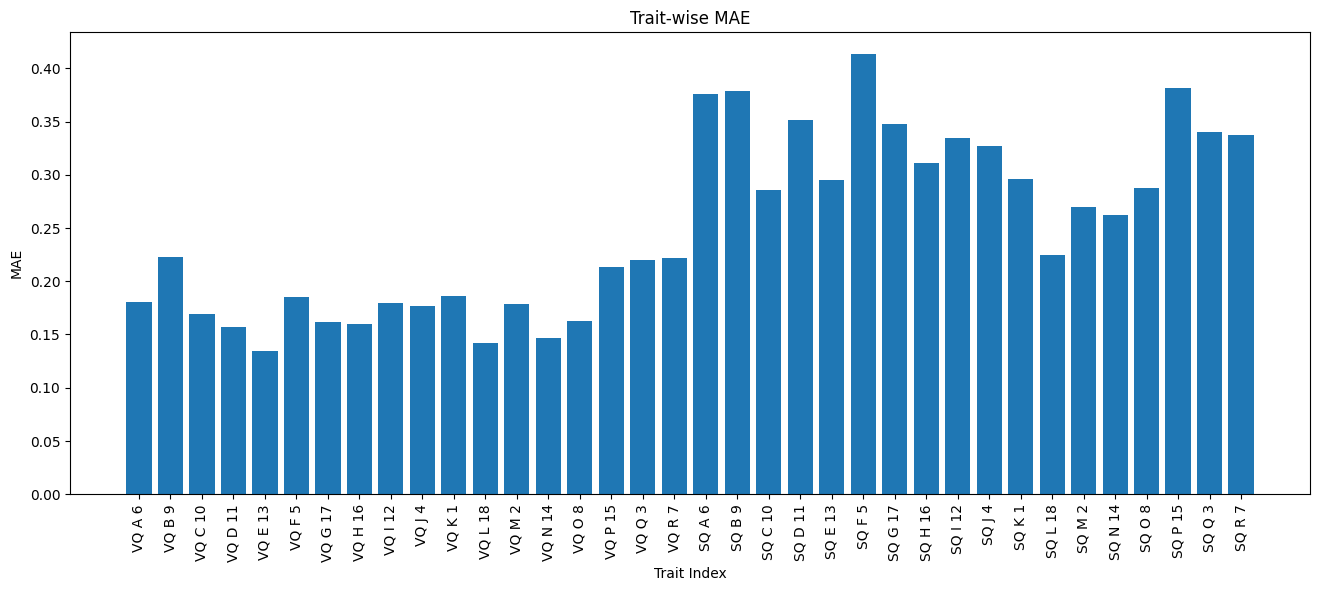

<Figure size 640x480 with 0 Axes>

In [80]:
from sklearn.metrics import mean_absolute_error

mae_scores = [mean_absolute_error(y[:, i], y_pred[:, i]) for i in range(36)]

plt.figure(figsize=(16,6))
plt.bar(traits, mae_scores)
plt.xlabel("Trait Index")
plt.xticks(rotation=90)
plt.ylabel("MAE")
plt.title("Trait-wise MAE")
plt.show()
plt.savefig("Trait-wise-mae.png", dpi=300, bbox_inches="tight")


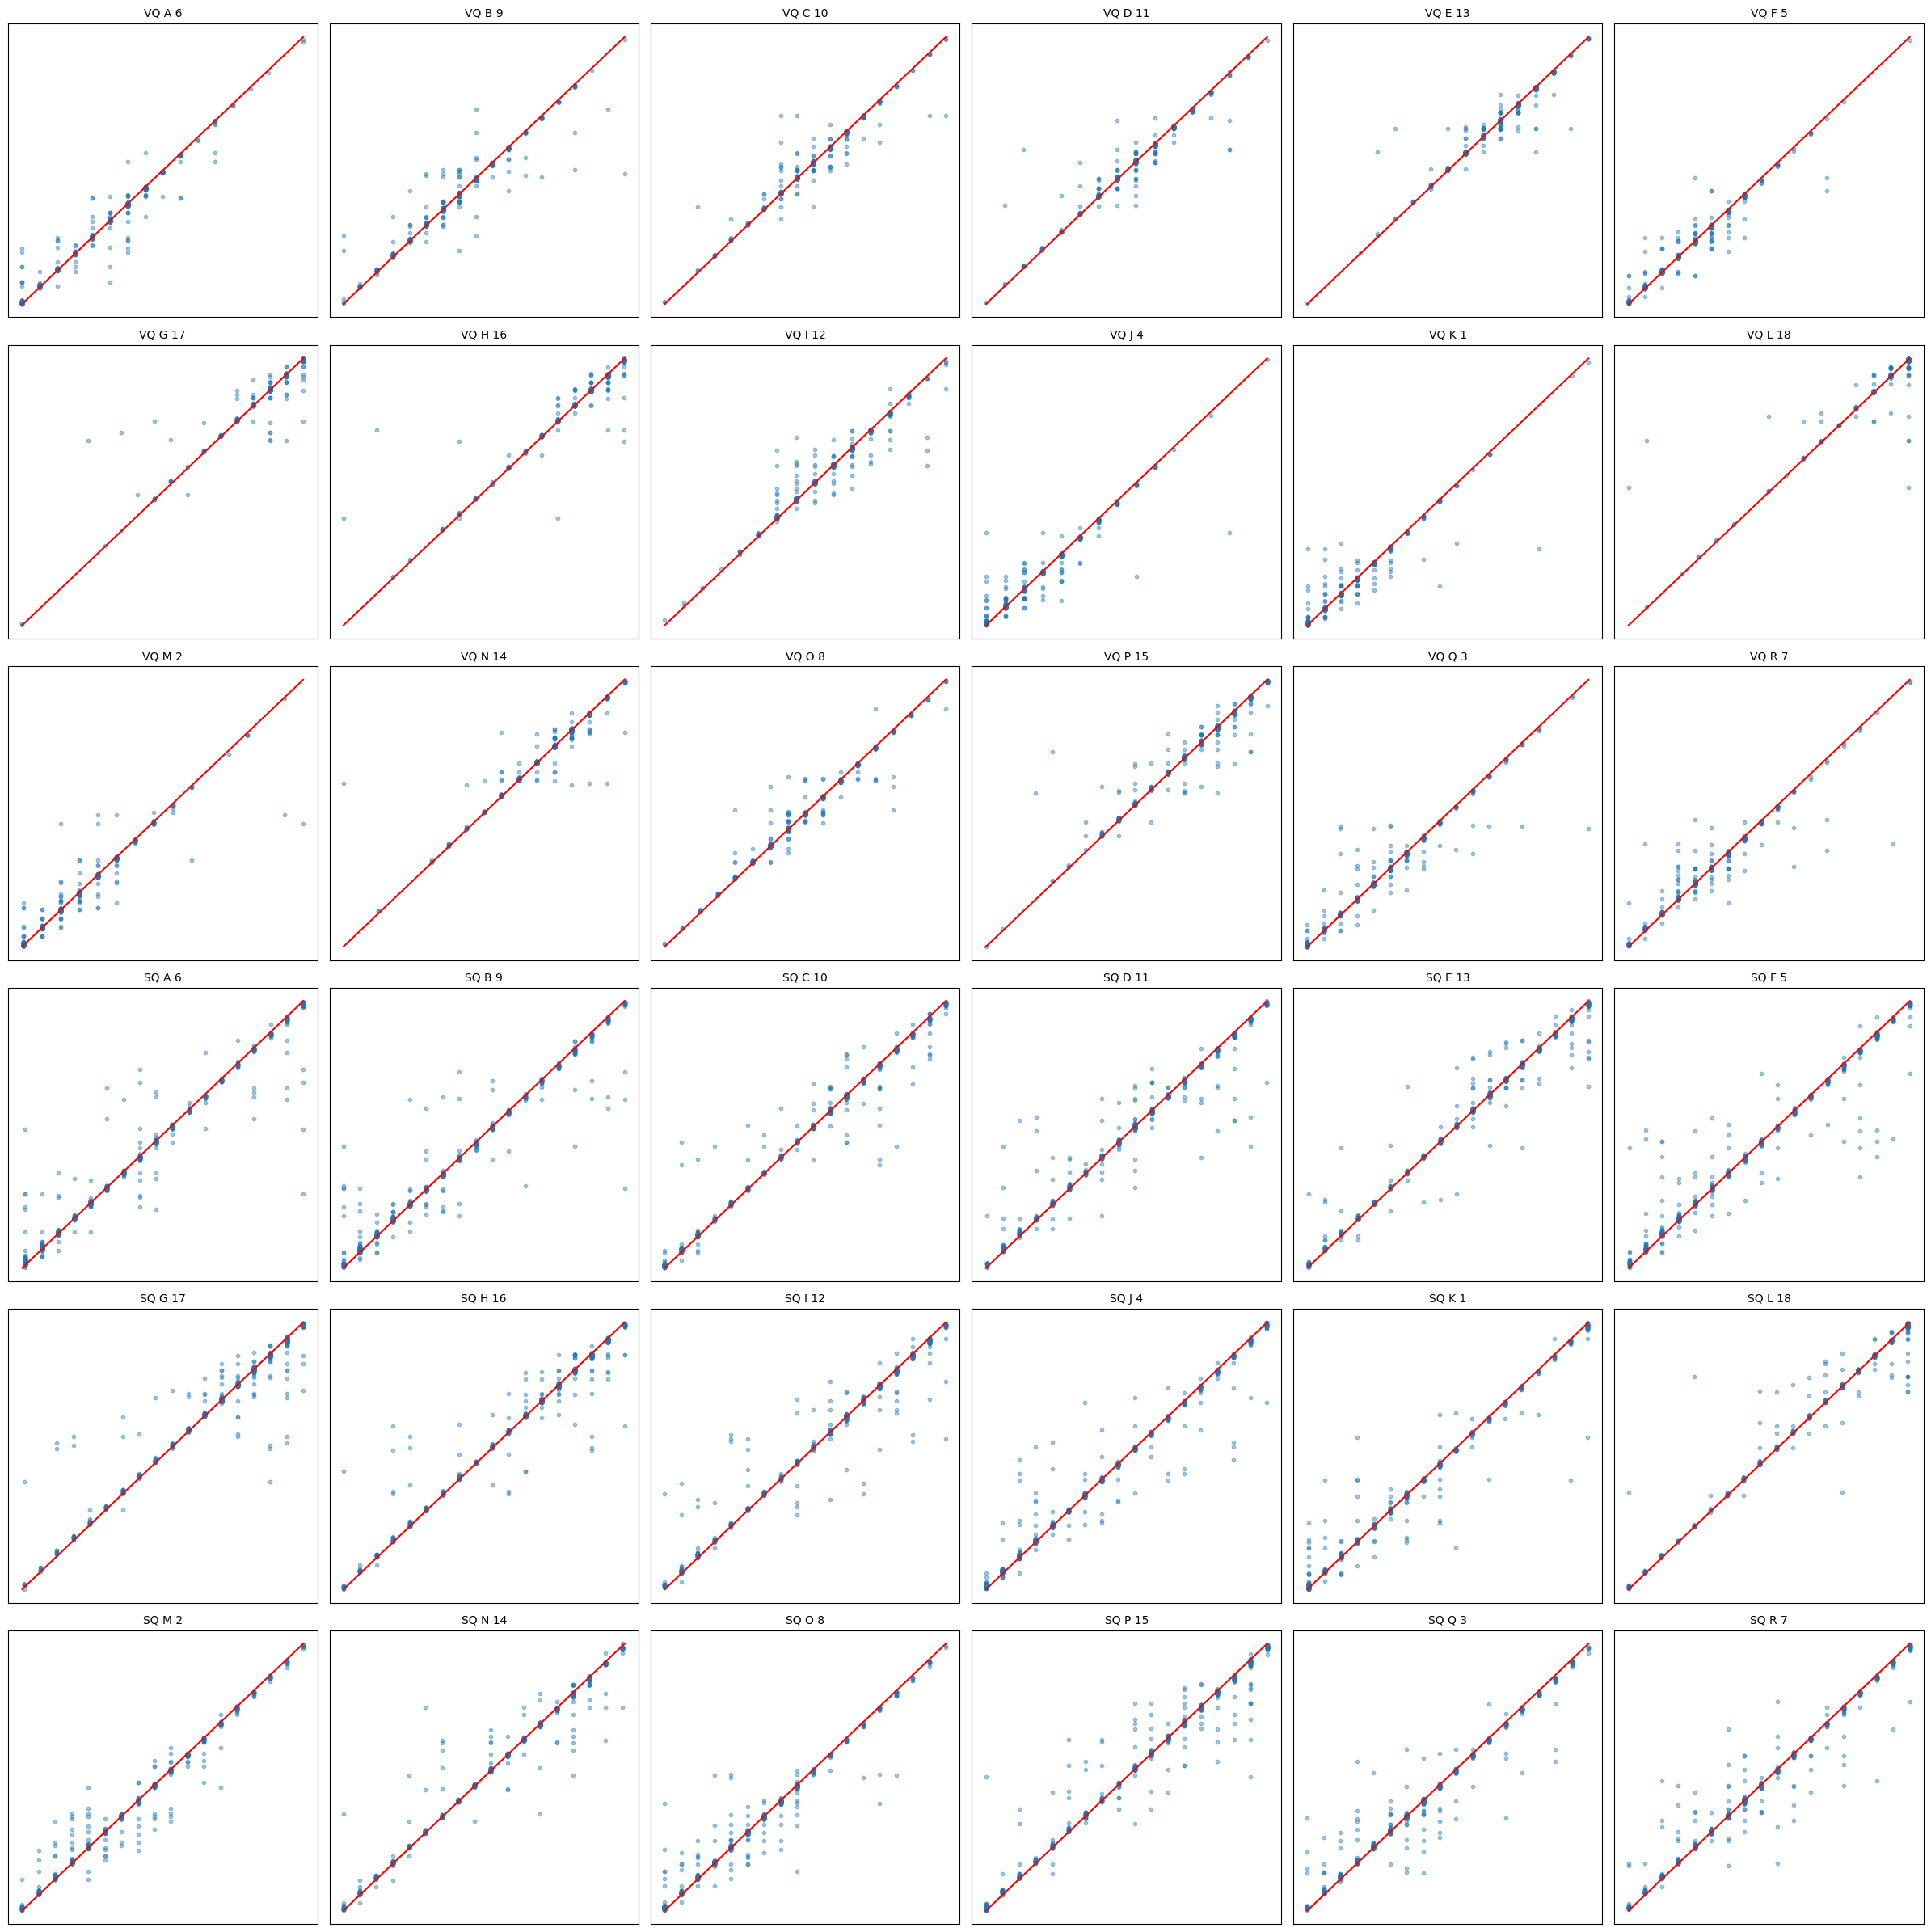

<Figure size 640x480 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Ensure arrays
y = np.asarray(y)
y_pred = np.asarray(y_pred)

num_traits = y.shape[1]

plt.figure(figsize=(24, 24))   # big figure for clarity

for i in range(num_traits):
    plt.subplot(6, 6, i+1)
    plt.scatter(y[:, i], y_pred[:, i], alpha=0.4, s=10)

    # perfect fit line
    min_val = min(y[:, i].min(), y_pred[:, i].min())
    max_val = max(y[:, i].max(), y_pred[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red')

    # title with trait name if available
    if 'traits' in globals():
        plt.title(traits[i], fontsize=10)
    else:
        plt.title(f"Trait {i}", fontsize=10)

    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()
plt.savefig("BestFitAllRankings.png", dpi=300, bbox_inches="tight")


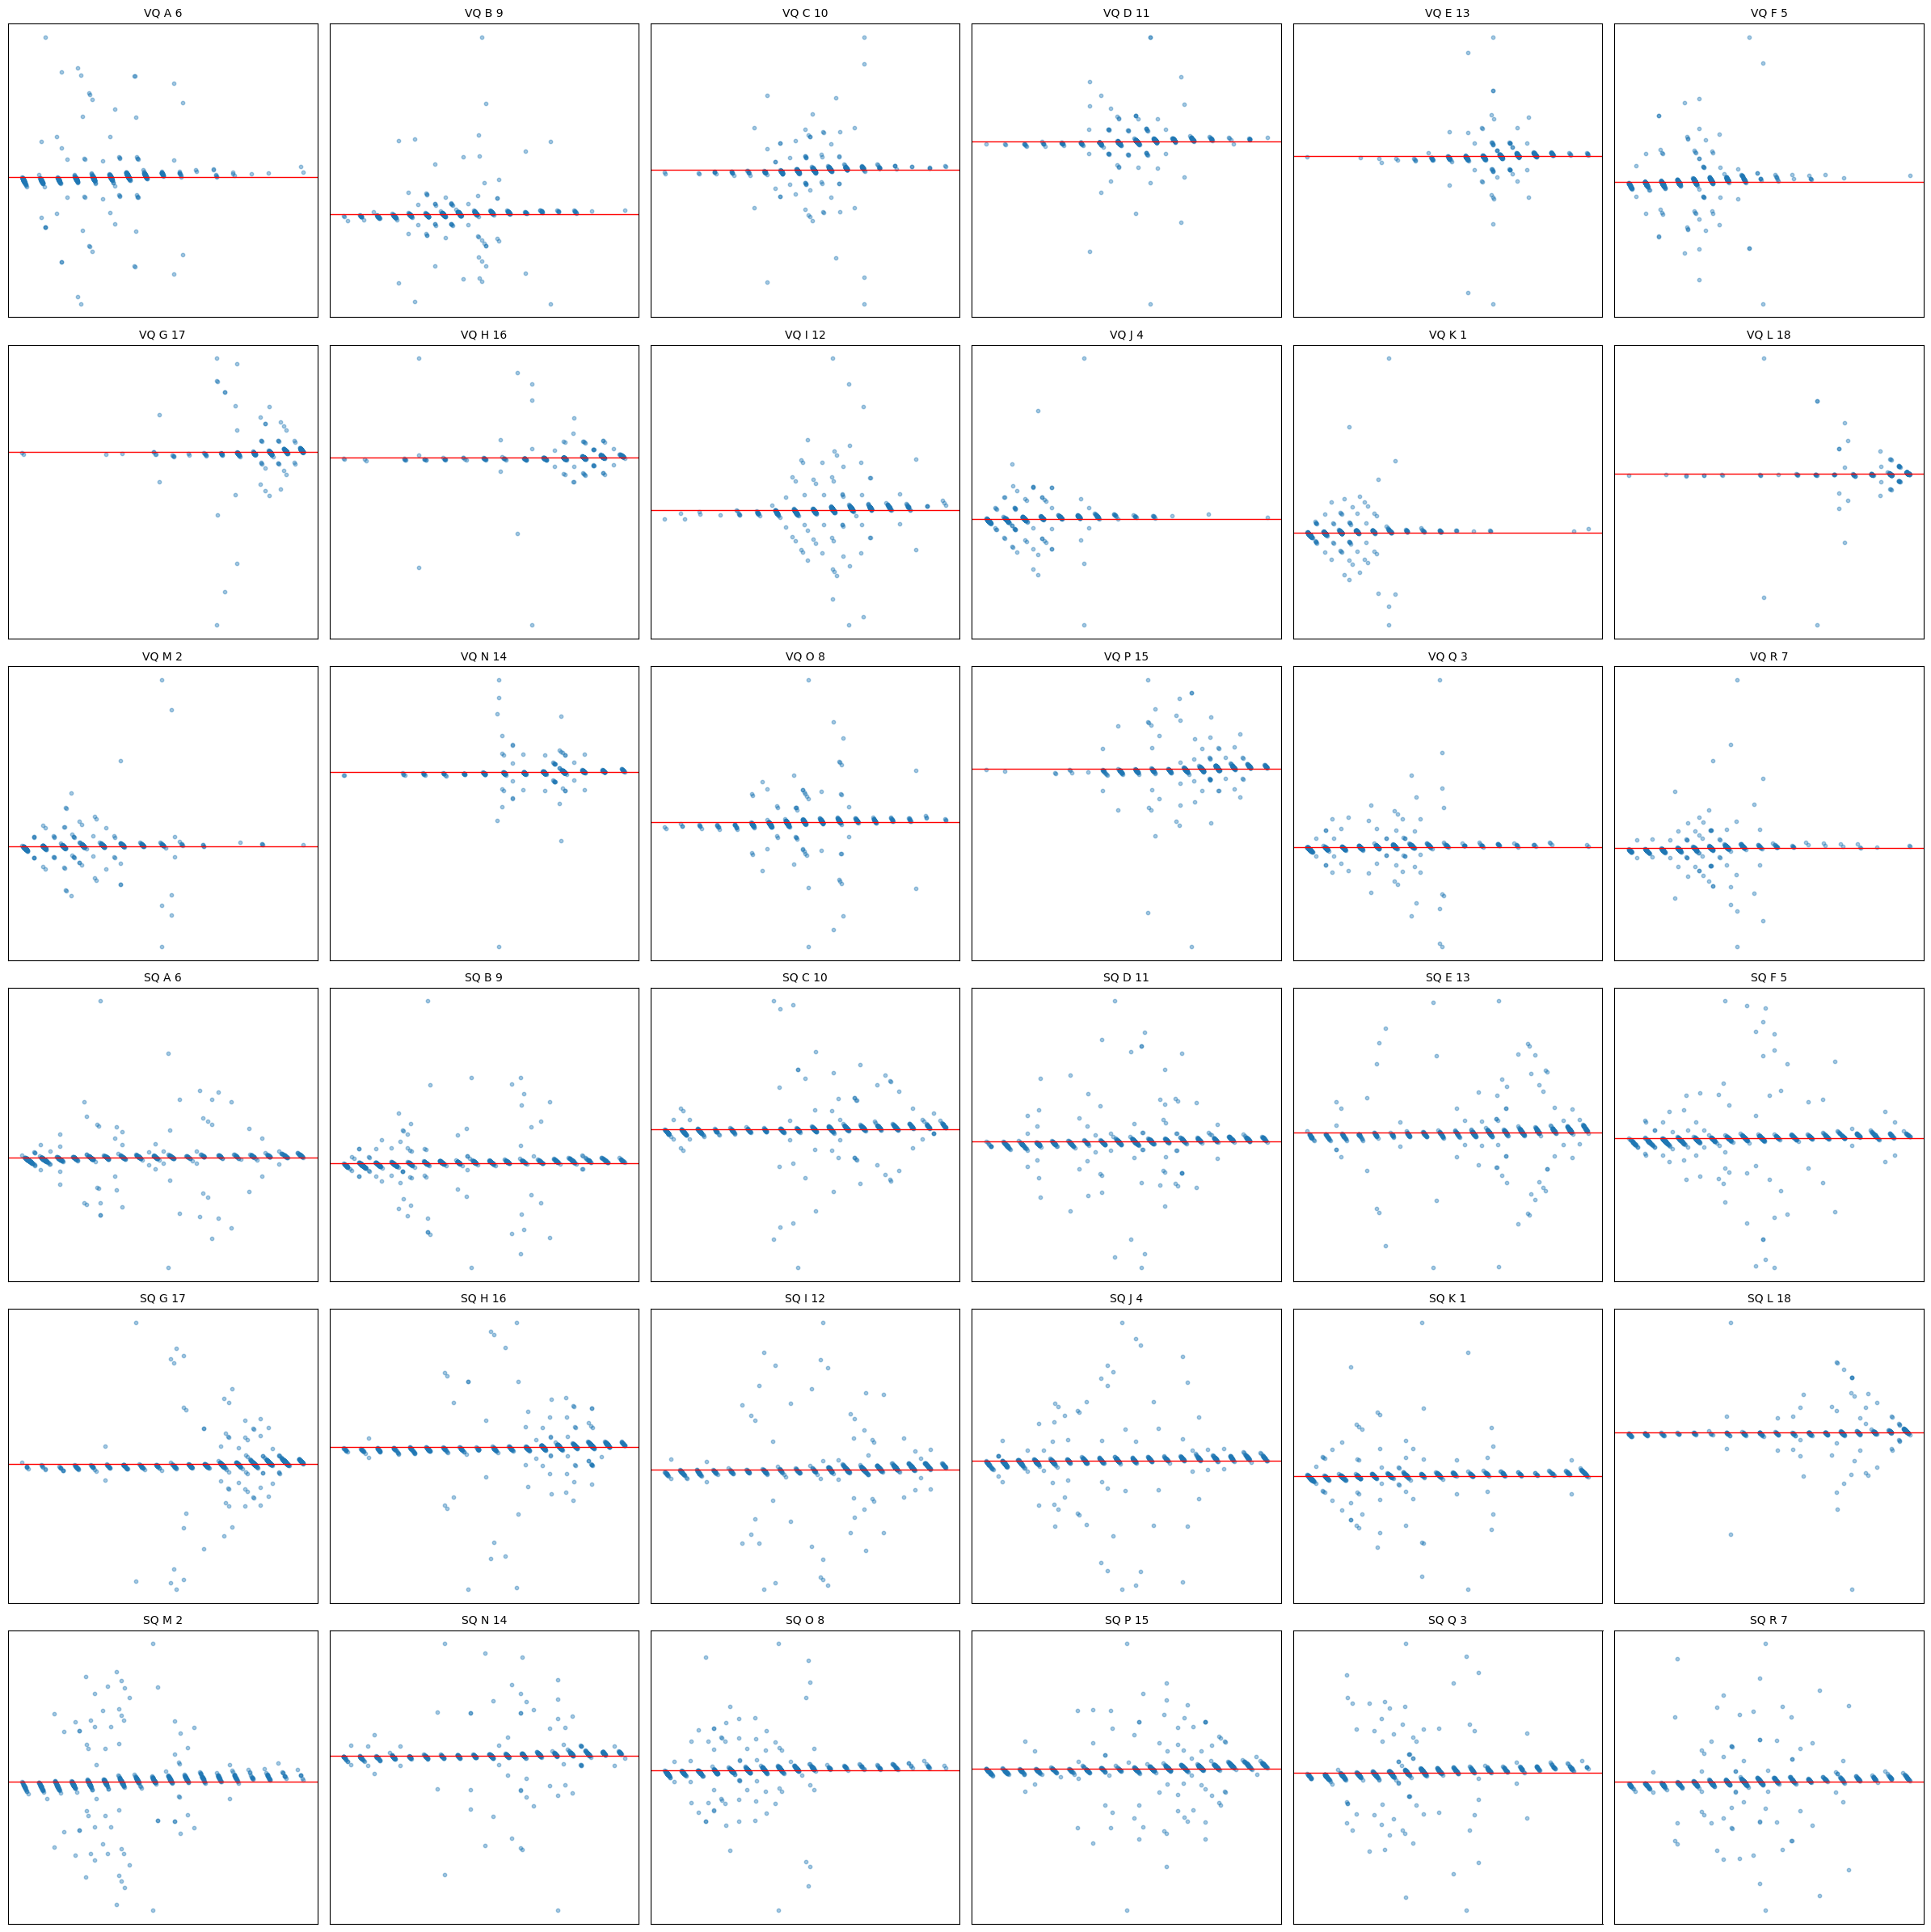

<Figure size 640x480 with 0 Axes>

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure numpy arrays
y = np.asarray(y)
y_pred = np.asarray(y_pred)

num_traits = y.shape[1]

plt.figure(figsize=(24, 24))

for i in range(num_traits):
    errors = y[:, i] - y_pred[:, i]

    plt.subplot(6, 6, i+1)
    plt.scatter(y_pred[:, i], errors, alpha=0.4, s=10)
    plt.axhline(0, color='red', linewidth=1)

    # Title with trait name if available
    if 'traits' in globals():
        plt.title(traits[i], fontsize=10)
    else:
        plt.title(f"Trait {i}", fontsize=10)

    # cleaner look
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

plt.savefig("ResidualAllRankings.png", dpi=300, bbox_inches="tight")

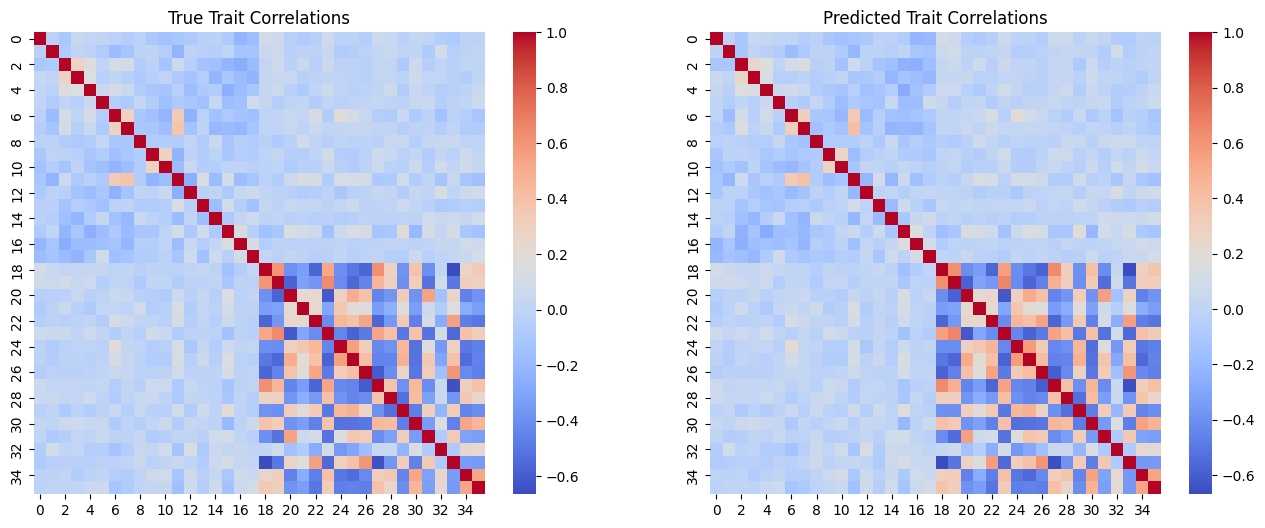

<Figure size 640x480 with 0 Axes>

In [58]:
import seaborn as sns
import numpy as np

corr_true = np.corrcoef(y.T)
corr_pred = np.corrcoef(y_pred.T)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.heatmap(corr_true, cmap='coolwarm')
plt.title("True Trait Correlations")

plt.subplot(1,2,2)
sns.heatmap(corr_pred, cmap='coolwarm')
plt.title("Predicted Trait Correlations")

plt.show()
plt.savefig("TruevsPredictedCorrelation.png", dpi=300, bbox_inches="tight")

In [59]:
import pandas as pd


df_results = pd.DataFrame({
    "Trait": traits,
    "R²": r2_scores,
    "MAE": mae_scores
})

df_results.to_excel('Report-R2-and-Mae-TraitWise.xlsx')

NameError: name 'r2_scores' is not defined

# Preparing Scores

In [60]:
import pandas as pd

In [61]:
dataset  =  pd.read_excel('data_for_hvp_rankings.xlsx')

In [62]:
dataset.head()

,Record ID#,Patient ID#,VQ A 6,VQ B 9,VQ C 10,VQ D 11,VQ E 13,VQ F 5,VQ G 17,VQ H 16,...,SQ J 4,SQ K 1,SQ L 18,SQ M 2,SQ N 14,SQ O 8,SQ P 15,SQ Q 3,SQ R 7,Message
0,5146,1977,7,9,8,11,15,6,16,14,...,14,17,13,8,15,1,9,2,16,No i'm driving actually I don't know if you ca...
1,5139,5422,6,7,18,16,17,8,15,14,...,3,9,10,11,15,14,13,16,12,i'm good. How the virus. know. The day before ...
2,5120,17915,1,9,8,10,12,2,11,13,...,3,10,18,4,9,5,15,6,7,hi. I always get stuck in those. Like which li...
3,5118,5422,1,8,9,10,11,7,18,17,...,7,8,15,9,14,10,13,11,12,i'm good. How the virus. know. The day before ...
4,5100,10859,7,6,10,11,13,8,17,16,...,4,5,10,7,13,6,14,8,9,Hello. yeah I can hear you. mmm i'm Stan stove...


In [63]:
traits = ['VQ A 6', 'VQ B 9', 'VQ C 10', 'VQ D 11',
       'VQ E 13', 'VQ F 5', 'VQ G 17', 'VQ H 16', 'VQ I 12', 'VQ J 4',
       'VQ K 1', 'VQ L 18', 'VQ M 2', 'VQ N 14', 'VQ O 8', 'VQ P 15', 'VQ Q 3',
       'VQ R 7', 'SQ A 6', 'SQ B 9', 'SQ C 10', 'SQ D 11', 'SQ E 13', 'SQ F 5',
       'SQ G 17', 'SQ H 16', 'SQ I 12', 'SQ J 4', 'SQ K 1', 'SQ L 18',
       'SQ M 2', 'SQ N 14', 'SQ O 8', 'SQ P 15', 'SQ Q 3', 'SQ R 7']

In [67]:
import json

all_predictions = []
for index,row in dataset.iterrows():
    text = row['Message']
    predicted  = predict_traits([text],model)
    output = {k: float(v) for k, v in zip(traits, predicted[0])}
    output['Record ID#'] = row['Record ID#']
    output['Patient ID#'] = row['Patient ID#']
    all_predictions.append(output)

In [69]:
output_df = pd.DataFrame(all_predictions)

In [70]:
output_df.to_excel('predicted_scores_with_ids.xlsx',index=False)

In [77]:
output_df[traits].iloc[0].values

array([ 9.5367651 , 10.21845722,  7.70251226,  9.1058712 , 11.10741901,
        8.19397831, 12.78888226,  7.83026028, 10.68165493,  6.1954999 ,
        5.85000992, 13.13082695,  7.87474728, 11.7993803 , 12.0574913 ,
       10.7846756 ,  8.49253178,  7.52247667, 12.37835693, 11.71222687,
        8.7379179 ,  4.07780361, 15.49116898,  8.07811451, 13.4390955 ,
        8.50502396, 10.44135571, 12.93021202,  7.92309856, 11.45926952,
        9.1671505 , 12.18299484,  3.47865105,  8.190938  ,  3.45215392,
        9.26871395])

In [82]:
r2_score(y,output_df[traits])

0.9431159011226027

In [72]:
y[0]

array([ 7,  9,  8, 11, 15,  6, 16, 14, 10,  1,  2, 18,  5, 17, 12, 13,  3,
        4,  6,  5,  7,  4, 18,  3, 11, 12, 10, 14, 17, 13,  8, 15,  1,  9,
        2, 16])